# Indicateur tourisme Côte d'Azur

1ère méthode :  
Essayer de prédire les données officielles à partir des données officielles passées uniquement.  
(pour essayer de mieux comprendre l'étude des séries temporelles)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Réduction des données officielles à la Côte d'Azur

In [2]:
#Importe données groupées par mois
df_France_Official_Data2 = pd.read_csv("df_France_Official_Data_month.csv", index_col=0)
df_France_Official_Data2['date'] = pd.to_datetime(df_France_Official_Data2['date'])

In [3]:
#Données Côte d'Azur
df_Official_Data_Sud = df_France_Official_Data2[(df_France_Official_Data2['department']=='Bouches-du-Rhône') 
                                               | (df_France_Official_Data2['department']=='Alpes-Maritimes')
                                               | (df_France_Official_Data2['department']=='Var')]
df_Official_Data_Sud.head(5)

,date,department,value_in_thousands
3,2011-01-01,Alpes-Maritimes,170.80
12,2011-01-01,Bouches-du-Rhône,153.08
89,2011-01-01,Var,62.69
99,2011-02-01,Alpes-Maritimes,205.43
108,2011-02-01,Bouches-du-Rhône,156.19


In [4]:
#On regroupe par mois
df_Official_Data_Sud2 = df_Official_Data_Sud.groupby('date').sum() 
df_Official_Data_Sud2.head(5)

,value_in_thousands
date,
2011-01-01,386.57
2011-02-01,434.73
2011-03-01,572.64
2011-04-01,738.92
2011-05-01,828.78


## Représentation de la série

<AxesSubplot:xlabel='date'>

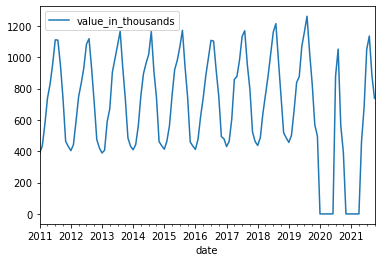

In [5]:
df_Official_Data_Sud2.plot()

/!\ Il y a bcp de valeurs à 0 en 2020 et 2021 avec le covid.

In [6]:
#On se restreint à une période stable ie avant le confinement. On garde les obs avant 2020.
df_Official_Data_Sud2_index = df_Official_Data_Sud2.reset_index()
df_Official_Data_Sud3 = df_Official_Data_Sud2_index[df_Official_Data_Sud2_index['date']<"2020-01-01"]
df_Official_Data_Sud3.set_index('date', inplace=True)
df_Official_Data_Sud3

,value_in_thousands
date,
2011-01-01,386.57
2011-02-01,434.73
2011-03-01,572.64
2011-04-01,738.92
2011-05-01,828.78
...,...
2019-08-01,1261.63
2019-09-01,1028.80
2019-10-01,828.72


## Stationnarité

La stationnarité signifie que les statistiques de la série temporelle ne dépendent pas du temps. En particulier cela veut dire que il n’y a pas de tendance générale et que les variations apparaissent comme d’amplitude constante. 

  
  
Il y a deux façons principales de déterminer si une série temporelle donnée est stationnaire:

Statistiques roulantes : Tracer la moyenne mobile et l’écart-type mobile. La série temporelle est stationnaire si elle reste constante dans le temps (à l’œil nu, regardez si les lignes sont droites et parallèles à l’axe des x)  
Test de Dickey-Fuller augmenté (ADF) : La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

### Méthode 1 : moyenne mobile sur 6 mois et écart-type mobile sur 6 mois

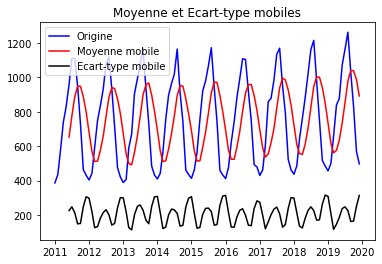

In [7]:
#Méthode 1 : moyenne mobile sur 6 mois et écart-type mobile sur 6 mois

rolling_mean = df_Official_Data_Sud3.rolling(window = 6).mean()
rolling_std = df_Official_Data_Sud3.rolling(window = 6).std()
plt.plot(df_Official_Data_Sud3, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

### Méthode 2 : Test ADF

In [8]:
#Methode 2 : Test ADF

result = adfuller(df_Official_Data_Sud3['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : 1.730396934364561
p-value : 0.9982005019252823
Valeurs Critiques :
	1%: -3.5003788874873405
	5%: -2.8921519665075235
	10%: -2.5830997960069446


La statistique ADF est loin des valeurs critiques et la p-value est supérieure à 0,05. Donc la série temporelle n’est pas stationnaire.

### On stationnarise la série

The most common and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary. So what is differencing? If Y_t is the value at time ‘t’, then the first difference of Y = Yt – Yt-1. 

In [9]:
#Différenciation de premier ordre
df_Official_Data_Sud3_diff = df_Official_Data_Sud3 - df_Official_Data_Sud3.shift()
df_Official_Data_Sud3_diff

,value_in_thousands
date,
2011-01-01,NaN
2011-02-01,48.16
2011-03-01,137.91
2011-04-01,166.28
2011-05-01,89.86
...,...
2019-08-01,99.60
2019-09-01,-232.83
2019-10-01,-200.08


<AxesSubplot:xlabel='date'>

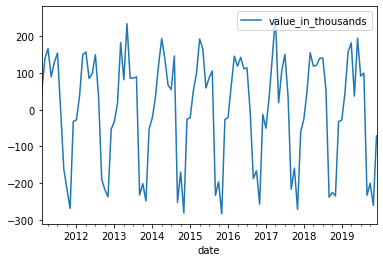

In [36]:
df_Official_Data_Sud3_diff.plot()

In [10]:
#On supprime le NA 
df_Official_Data_Sud3_diff.dropna(inplace=True)

In [11]:
#Test ADF

result = adfuller(df_Official_Data_Sud3_diff['value_in_thousands'])
 
print('Statistiques ADF : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Valeurs Critiques :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

Statistiques ADF : -20.923325269098676
p-value : 0.0
Valeurs Critiques :
	1%: -3.5003788874873405
	5%: -2.8921519665075235
	10%: -2.5830997960069446


La p-value est <0,05, la série est stationnaire.

## Décomposition

La décomposition d’une série temporelle consiste à séparer sa série initiale en plusieurs sous-séries plus simples, chacune représentant un aspect essentiel de la série initiale. Une décomposition typique est la décomposition en 3 séries: tendance, périodique et reste. On retrouve la série originale si on somme les 3 séries composantes.

Dans le graphe ci-dessous on sépare les composantes de tendance, périodique, et le reste avant de les afficher. Notez que l’on applique la décomposition à la série dont la variance a été stabilisée, afin d’avoir une composante périodique qui reste stable dans le temps. Pour l’affichage, on inverse la transformation logarithmique (avec la fonction ‘exp’) pour avoir les données dans l’unité originale.

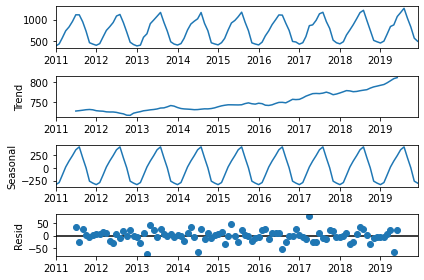

In [12]:
decompose = seasonal_decompose(df_Official_Data_Sud3, period=12) #je ne sais pas quelle valeur mettre à period
decompose.plot()
plt.show()

## Fonction d'auto-corrélation (ACF) et d'auto-corrélation partielle (PACF)

Trois entiers (p, d, q) sont généralement utilisés pour paramétrer les modèles ARIMA :  
p : nombre de termes autorégressifs (ordre AR)  
d : nombre de différences non saisonnières (ordre de différenciation)  
q : nombre de termes moyens mobiles (ordre MA)  

Nous pouvons utiliser l’ACF pour déterminer le nombre optimal de termes MA. Nous pouvons utiliser le PACF pour déterminer le nombre optimal de termes à utiliser dans le modèle AR. 

C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


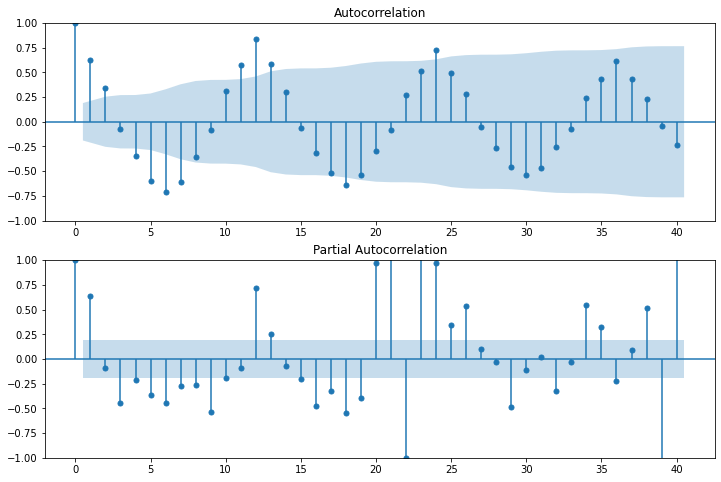

In [13]:
#sur la série différenciée

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_Official_Data_Sud3_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_Official_Data_Sud3_diff, lags=40, ax=ax2); #comment on choisit lag= ?

ACF : utiliser les 13 mois précédents dans l'équation de la moyenne mobile.  
PACF : utiliser les ???? mois précédents dans l'équation d'auto-régression.

## Modèle ARIMA

### Modèle ARIMA

On crée et ajuste un modèle ARIMA avec un AR d’ordre ?, une différence d’ordre 1 et un MA d’ordre 13.

In [14]:
model = ARIMA(df_Official_Data_Sud3, order=(12,1,13)) #(p,d,q)
results_ARIMA = model.fit()
results_ARIMA.summary()

C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\base\model.py:60

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     value_in_thousands   No. Observations:                  108
Model:               ARIMA(12, 1, 13)   Log Likelihood                -529.896
Date:                Thu, 17 Mar 2022   AIC                           1111.792
Time:                        14:02:15   BIC                           1181.285
Sample:                    01-01-2011   HQIC                          1139.964
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4947      0.385     -1.284      0.199      -1.250       0.260
ar.L2          0.4302      0.362      1.188      0.235      -0.279       1.140
ar.L3         -0.0280      0.393     -0.071      0.943      -0.798       0.742
ar.L4         -0.4781      0.367     -1.304      0.192      -1.197       0.240
ar.L5          0.3956      0.343      1.153      0.249      -0.277       1.068
ar.L6         -0.0476      0.369     -0.129      0.897      -0.771       0.676
ar.L7         -0.4485      0.360     -1.246      0.213      -1.154       0.257
ar.L8          0.4279      0.333      1.285      0.199      -0.225       1.080
ar.L9         -0.0786      0.362     -0.217      0.828      -0.789       0.632
ar.L10        -0.4746      0.373     -1.273      0.203      -1.205       0.256
ar.L11         0.4542      0.341      1.330      0.183      -0.215       1.123
ar.L12         0.9383      0.378      2.484      0.013       0.198       1.679
ma.L1         -0.4576      3.819     -0.120      0.905      -7.943       7.027
ma.L2         -0.8897      5.501     -0.162      0.872     -11.671       9.892
ma.L3          0.2925      9.421      0.031      0.975     -18.172      18.757
ma.L4          0.4277      4.762      0.090      0.928      -8.906       9.761
ma.L5         -0.7361     13.503     -0.055      0.957     -27.202      25.730
ma.L6          0.4442      3.626      0.122      0.903      -6.663       7.552
ma.L7          0.3650      5.283      0.069      0.945      -9.990      10.720
ma.L8         -0.6471      8.388     -0.077      0.939     -17.087      15.793
ma.L9          0.4727      8.718      0.054      0.957     -16.614      17.560
ma.L10         0.3535      6.471      0.055      0.956     -12.329      13.036
ma.L11        -0.9450     12.268     -0.077      0.939     -24.989      23.099
ma.L12        -0.4256      2.060     -0.207      0.836      -4.463       3.611
ma.L13         0.8578      6.823      0.126      0.900     -12.515      14.230
sigma2       883.2876   6831.028      0.129      0.897   -1.25e+04    1.43e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.67   Prob(JB):                         0.54
Heteroskedasticity (H):               1.21   Skew:                             0.23
Prob(H) (two-sided):                  0.58   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.04e+14. Standard errors may be unstable.
"""

Aucun coeff n'est différent de 0 --> modèle pas significatif.

In [15]:
model2 = ARIMA(df_Official_Data_Sud3, order=(2,1,3)) #(p,d,q)
results_ARIMA2 = model2.fit()
results_ARIMA2.summary()

C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Clemence\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWar

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     value_in_thousands   No. Observations:                  108
Model:                 ARIMA(2, 1, 3)   Log Likelihood                -589.722
Date:                Thu, 17 Mar 2022   AIC                           1191.444
Time:                        14:02:16   BIC                           1207.481
Sample:                    01-01-2011   HQIC                          1197.945
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7293      0.004    462.385      0.000       1.722       1.737
ar.L2         -0.9974      0.003   -313.960      0.000      -1.004      -0.991
ma.L1         -2.7144      0.175    -15.516      0.000      -3.057      -2.372
ma.L2          2.6119      0.344      7.595      0.000       1.938       3.286
ma.L3         -0.8796      0.173     -5.096      0.000      -1.218      -0.541
sigma2      3334.9875    803.345      4.151      0.000    1760.460    4909.515
===================================================================================
Ljung-Box (L1) (Q):                   4.67   Jarque-Bera (JB):                 0.36
Prob(Q):                              0.03   Prob(JB):                         0.84
Heteroskedasticity (H):               1.30   Skew:                             0.11
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Tous les coeff sont significatifs car les p-values sont inférieures à 5%.

### Résidus

We can also do line and density plot of residuals.

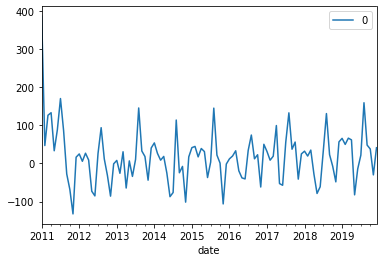

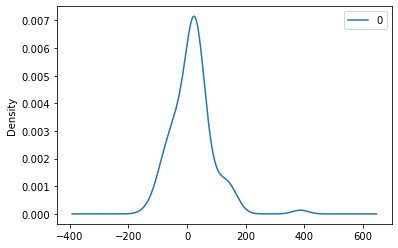

                0
count  108.000000
mean    18.322006
std     69.885778
min   -132.422684
25%    -26.205958
50%     19.311883
75%     42.366453
max    386.570000


In [22]:
residuals = pd.DataFrame(results_ARIMA2.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

As we see above, mean is not exactly zero that means there is some bias in the data.

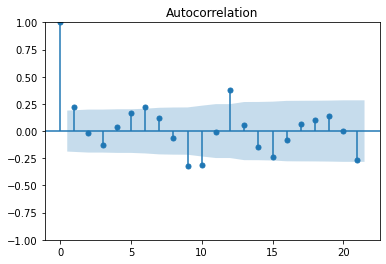

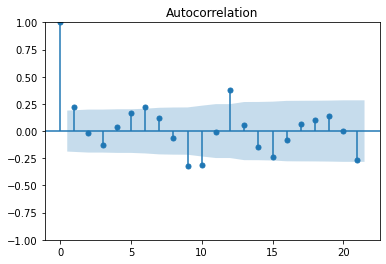

In [23]:
plot_acf(residuals)

Les résidus ont quelques autocorrélations en dehors de l'intervalle de confiance.

### Test portmanteau

In [28]:
import statsmodels.api as sm

sm.stats.acorr_ljungbox(residuals)

,lb_stat,lb_pvalue
1,5.489680,0.019129
2,5.511236,0.063570
3,7.276753,0.063581
4,7.400668,0.116170
5,10.642471,0.058948
6,16.591369,0.010908
7,18.412859,0.010240
8,18.903646,0.015384
9,31.110548,0.000283
10,42.885859,0.000005


Les p-value sont faibles (toutes <5% sauf au lag 4) : on rejette le modèle ARIMA(2,1,3)

### Prédiction

Étant donné que nous disposons de données pour chaque mois remontant à 10 ans et que nous voulons prévoir le nombre de touristes sur la Côte d'Azur pour les 10 prochaines années, nous utilisons (12 x 10) + (12 x 10) = 240.

C:\Users\Clemence\AppData\Local\Temp/ipykernel_94028/3228083007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Official_Data_Sud3['forecast'] = results_ARIMA2.predict(start=1, end=108)


<AxesSubplot:xlabel='date'>

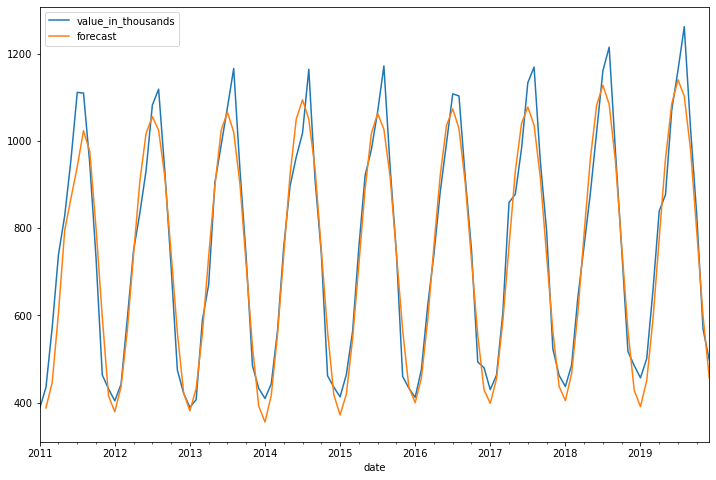

In [31]:
df_Official_Data_Sud3['forecast'] = results_ARIMA2.predict(start=1, end=108)
df_Official_Data_Sud3[['value_in_thousands','forecast']].plot(figsize=(12,8))

La prédiction est bien.

In [32]:
from pandas.tseries.offsets import DateOffset
future_dates=[df_Official_Data_Sud3.index[-1]+ DateOffset(months=x)for x in range(0,60)] #on rajoute 5 années

In [33]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_Official_Data_Sud3.columns)
future_datest_df.head(5) #on a les dates de 2020 à 2024, avec aucune observation comme c'est ce qu'on prédit

,value_in_thousands,forecast
2020-01-01,NaN,NaN
2020-02-01,NaN,NaN
2020-03-01,NaN,NaN
2020-04-01,NaN,NaN
2020-05-01,NaN,NaN


In [34]:
future_df=pd.concat([df_Official_Data_Sud3,future_datest_df]) #on concatène les dates avec des obs et les dates qu'on prédit

<AxesSubplot:>

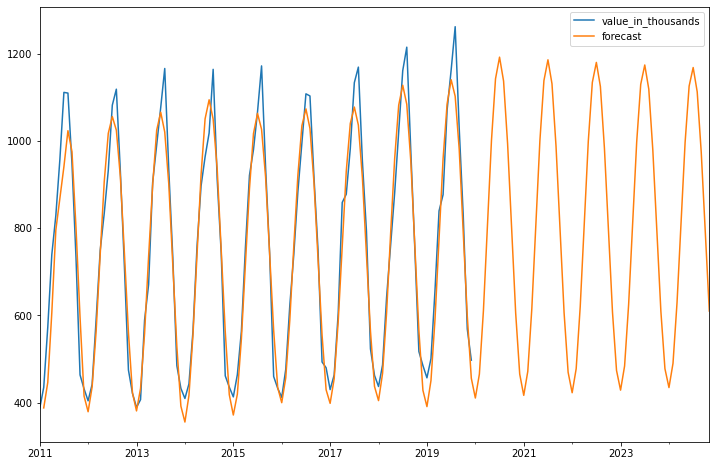

In [35]:
future_df['forecast'] = results_ARIMA2.predict(start = 1, end = 167)  
future_df[['value_in_thousands', 'forecast']].plot(figsize=(12, 8)) 